In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from random import random
from glob import glob
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data exploration

In [3]:
df = pd.read_csv("./datasets/chinesemnist/chinese_mnist.csv")
df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [4]:
paths = glob("./datasets/chinesemnist/data/data/*.jpg")
# Shuffle paths
paths = np.random.permutation(paths)
# Split into train, validation, and test with 70%, 15%, 15% split
train_paths = paths[:int(len(paths)*0.7)]
val_paths = paths[int(len(paths)*0.7):int(len(paths)*0.85)]
test_paths = paths[int(len(paths)*0.85):]
print(len(train_paths), len(val_paths), len(test_paths))

10500 2250 2250


In [5]:
def load_images(paths):
    images = []
    ids = []
    for path in paths:
        char_idx = int(path.split("_")[-1][:-4])
        images.append(plt.imread(path))
        ids.append(char_idx)
    return np.array(images), ids

train_images, train_ids = load_images(train_paths)
val_images, val_ids = load_images(val_paths)
test_images, test_ids = load_images(test_paths)
print(train_images.shape, val_images.shape, test_images.shape)

(10500, 64, 64) (2250, 64, 64) (2250, 64, 64)


Now we have a dataset 
$$
(X_{i...N_{train/test/val}}, Y_{i...N_{train/test/val}})
$$ 
Where $X_{train_i} \in \mathbb{R^{64 \times 64}}$ is a train image example of dimensions 64 by 64 pixels. and $Y_i \in \mathbb{Z}$ represents the character index 

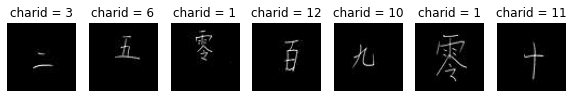

In [6]:
nsamples = 7
for i in range(nsamples):
    plt.subplot(1, nsamples, i+1).imshow(train_images[i], cmap="gray")
    plt.subplot(1, nsamples, i+1).set_title(f"charid = {train_ids[i]}")
    plt.axis("off")
plt.gcf().set_size_inches(10, 10)
plt.show()

We want to match the images head to head in a fully connected manner such that the new dataset will be pairs of images and a similarity score.
$$
(X^l_{i...N_{train/test/val} \times N_{train/test/val}}, X^r_{i...N_{train/test/val} \times N_{train/test/val}}, Y_{i...N_{train/test/val} \times N_{train/test/val}})
$$
Where $X^l_{train_i} \in \mathbb{R^{64 \times 64}}$ is a the left image example of dimensions 64 by 64 pixels. and $Y_i \in [0..1] \subset \mathbb{R}$ represents the similarity score

In [7]:
def indices2similarities(X, Y):
    N = len(X)
    D = []
    for i in range(N):
        for j in range(N):
            left = X[i]
            right = X[j]
            score = 1.0 if Y[i] == Y[j] else 0.0
            D.append((left, right, score))
    return D

def get_sim_example(X, Y, i):
    N = len(X)**2
    if i >= N:
        raise ValueError("i must be less than len(X)**2")
    row = i // N
    col = i % len(X)
    left = X[row]
    right = X[col]
    score = 1.0 if Y[row] == Y[col] else 0.0
    return left, right, score
    
def plot_sample(left, right, score):
    plt.subplot(1, 2, 1).imshow(left, cmap="gray")
    plt.subplot(1, 2, 2).imshow(right, cmap="gray")
    plt.title(f"match={score==1}, sample={i}")
    plt.axis("off")

def plot_example_i(X, Y, i):
    left, right, score = get_sim_example(X, Y, i)
    plot_sample(left, right, score)

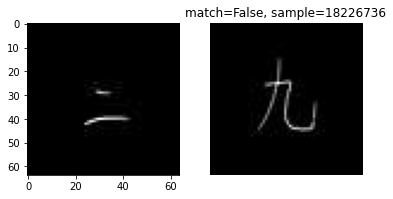

In [8]:
# Get random sample
i = np.random.randint(0, len(train_images)**2)
plot_example_i(train_images, train_ids, i)

**Potential problem**: Since there are $N \times N$ examples, assuming that image $X_i$ matches with $m$ other samples, then there are $N*m$ matching examples, therefore, the portion of matching examples in the dataset is 
$$
portion = \frac{N\cdot m}{N \times N} = \frac{m}{N}
$$
Therefore, you can already see that the portion becomes smaller in an exponential decay maner as $N$ grows, which can create a considerable data imbalance.

### Creating the datasets
Now that we have defined our dataset, we can create a PyTorch dataset that will be used for the later stages of training.

In [9]:

class ToTensor:

    def __call__(self, image):
       return torch.from_numpy(image)

transform = transforms.Compose([
    transforms.RandomInvert(),
    transforms.RandomChoice([
        transforms.RandomRotation(40),
        transforms.GaussianBlur(5),
        transforms.RandomPerspective()
    ])
])

In [10]:
class ChineseMNISTDataset(Dataset):

    def __init__(self, X, Y, transform=None, m=8):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.m = m
    
    def __len__(self):
        return self.X.shape[0] * self.m
    
    def __getitem__(self, index):
        N = self.X.shape[0]
        choice = np.random.choice([0, 1])
        row = i // N
        col = np.random.randint(0, N)
        score = 1.0 if self.Y[row] == self.Y[col] else 0.0
        while not score == choice:
            col = np.random.randint(0, N)
            score = 1.0 if self.Y[row] == self.Y[col] else 0.0
        left = self.X[row]
        right = self.X[col]
        left = self.__process_raw_image(left)
        right = self.__process_raw_image(right)

        if self.transform:
            left = self.transform(left)
            right = self.transform(right)
        return left, right, score

    def __process_raw_image(self, x):
        # Add a channel
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)
        x /= 255.0
        return x

In [11]:
train_ds = ChineseMNISTDataset(train_images, train_ids)
val_ds = ChineseMNISTDataset(val_images, val_ids)
test_ds = ChineseMNISTDataset(test_images, test_ids)

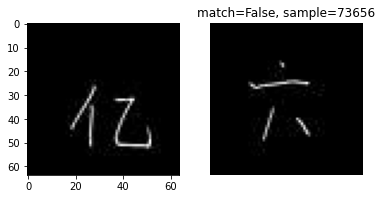

In [12]:
# Get random sample
i = np.random.randint(0, len(train_ds))
left, right, score = train_ds[i]
plot_sample(left[0], right[0], score)

## Modelling

In [13]:
from model import SiameseNetwork
from torch.nn import CosineEmbeddingLoss, CrossEntropyLoss
from losses import ContrastiveLoss
from torchmetrics.classification import BinaryF1Score
import tqdm

model = SiameseNetwork().to(device)
criterion = ContrastiveLoss().to(device)
metric = BinaryF1Score().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def load_state_dict(model, path):
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)

load_state_dict(model, "bestmodel3.pt")

f"{sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters"

'29137473 trainable parameters'

In [14]:
N = 50
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=True)
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

84000 18000 18000


In [15]:
# Compute F1 score metric
def compute_metric(model, metric=BinaryF1Score(), loader=None):
    model.eval()
    criterion = ContrastiveLoss()
    if loader is None:
        loader = val_loader

    running_loss = 0.0
    running_metric = 0.0
    compare = torch.nn.CosineSimilarity(dim=1)
    with torch.no_grad():
        for i, (left, right, score) in tqdm.tqdm(enumerate(loader), total=len(loader)):
            left = left.to(device)
            right = right.to(device)
            score = score.to(device)
            out0, out1 = model(left, right)
            loss = criterion(out0, out1, 1-score)
            running_loss += loss.item()

            similarities = model.compare_embeddings(out0, out1)
            # Compute cosine similarity
            running_metric += metric(score, (similarities < 0.5).float()).item()

    return running_loss/len(loader), running_metric/len(loader)

100%|██████████| 71/71 [00:05<00:00, 12.94it/s]


Epoch 1/50, epoch_loss 0.456, epoch_metric=0.737, val_loss 0.216, val_metric 0.942
saving model for metric 0.942


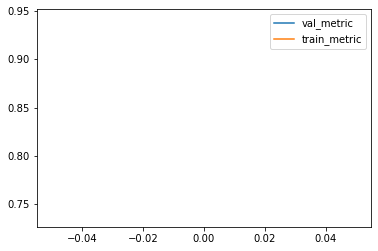

100%|██████████| 71/71 [00:05<00:00, 12.94it/s]


Epoch 2/50, epoch_loss 0.228, epoch_metric=0.904, val_loss 0.155, val_metric 0.966
saving model for metric 0.966


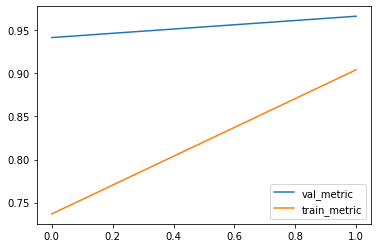

100%|██████████| 71/71 [00:05<00:00, 12.91it/s]


Epoch 3/50, epoch_loss 0.159, epoch_metric=0.932, val_loss 0.067, val_metric 0.993
saving model for metric 0.993


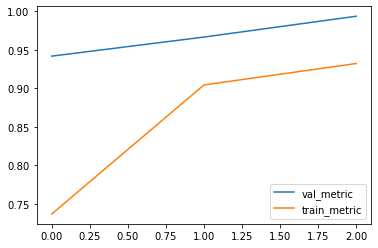

100%|██████████| 71/71 [00:05<00:00, 12.87it/s]

Epoch 4/50, epoch_loss 0.140, epoch_metric=0.941, val_loss 0.024, val_metric 0.983


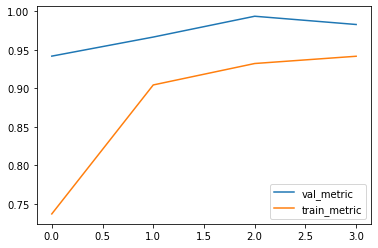

100%|██████████| 71/71 [00:05<00:00, 12.89it/s]


Epoch 5/50, epoch_loss 0.079, epoch_metric=0.969, val_loss 0.013, val_metric 0.995
saving model for metric 0.995


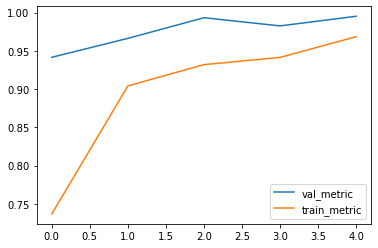

100%|██████████| 71/71 [00:05<00:00, 12.93it/s]


Epoch 6/50, epoch_loss 0.064, epoch_metric=0.975, val_loss 0.011, val_metric 0.992


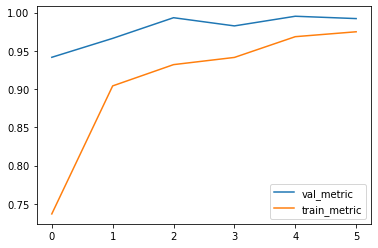

100%|██████████| 71/71 [00:05<00:00, 12.96it/s]

Epoch 7/50, epoch_loss 0.054, epoch_metric=0.980, val_loss 0.013, val_metric 0.989


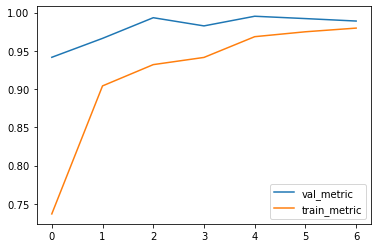

100%|██████████| 71/71 [00:05<00:00, 12.89it/s]


Epoch 8/50, epoch_loss 0.040, epoch_metric=0.985, val_loss 0.009, val_metric 0.995


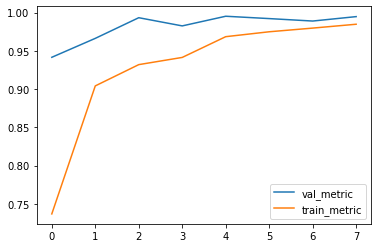

100%|██████████| 71/71 [00:05<00:00, 12.92it/s]

Epoch 9/50, epoch_loss 0.059, epoch_metric=0.979, val_loss 0.009, val_metric 0.990


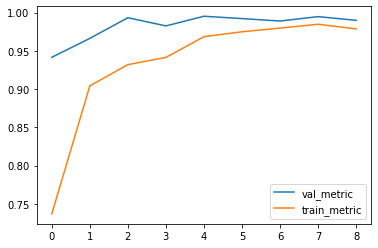

100%|██████████| 71/71 [00:05<00:00, 12.92it/s]


Epoch 10/50, epoch_loss 0.031, epoch_metric=0.988, val_loss 0.007, val_metric 0.999
saving model for metric 0.999


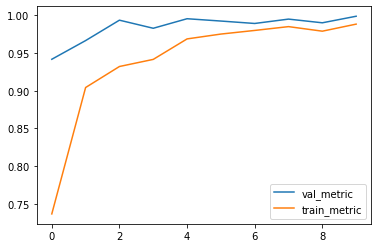

100%|██████████| 71/71 [00:05<00:00, 12.94it/s]

Epoch 11/50, epoch_loss 0.028, epoch_metric=0.989, val_loss 0.008, val_metric 0.992


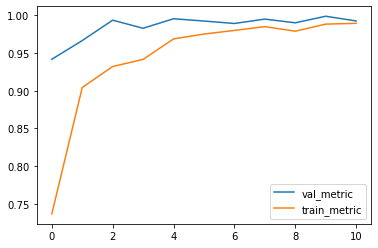

100%|██████████| 71/71 [00:05<00:00, 12.93it/s]

Epoch 12/50, epoch_loss 0.026, epoch_metric=0.990, val_loss 0.068, val_metric 0.985


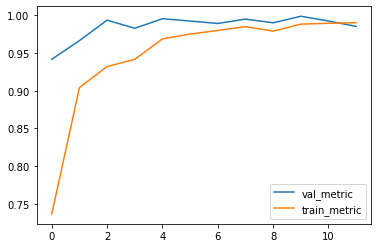

  7%|▋         | 22/329 [00:05<01:12,  4.23it/s]


KeyboardInterrupt: 

In [16]:

val_losses = []
train_losses = []
val_metrics = []
train_metrics = []
best_metric = 0


for epoch in range(N):
    model.train()
    running_epoch_loss = 0.0
    running_epoch_metric = 0.0

    for i, (left, right, score) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        
        left = left.to(device)
        right = right.to(device)
        score = score.to(device)
        # Runtime augmentation
        left = transform(left)
        right = transform(right)

        optimizer.zero_grad()
        out0, out1 = model(left, right)
        loss = criterion(out0, out1, 1-score)
        running_epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        similarities = model.compare_embeddings(out0, out1)

        # Compute cosine similarity
        running_epoch_metric += metric(score, (similarities < 0.5).float()).item()

    # Epoch complete
    val_loss, val_metric = compute_metric(model, loader=val_loader, metric=metric)
    train_loss, train_metric = running_epoch_loss/len(train_loader), running_epoch_metric/len(train_loader) 
    print(f"Epoch {epoch+1}/{N}, epoch_loss {train_loss:.3f}, epoch_metric={train_metric:.3f}, val_loss {val_loss:.3f}, val_metric {val_metric:.3f}")

    val_losses.append(val_loss)
    train_losses.append(train_loss)
    val_metrics.append(val_metric)
    train_metrics.append(train_metric)

    if val_metric >= best_metric:
        best_metric = val_metric
        print(f"saving model for metric {best_metric:.3f}")
        torch.save(model.state_dict(), "bestmodel4.pt")

    # plt.plot(val_losses, label="val_loss")
    # plt.plot(train_losses, label="train_loss")
    plt.plot(val_metrics, label="val_metric")
    plt.plot(train_metrics, label="train_metric")
    plt.legend()
    plt.show()

AttributeError: 'float' object has no attribute 'cpu'

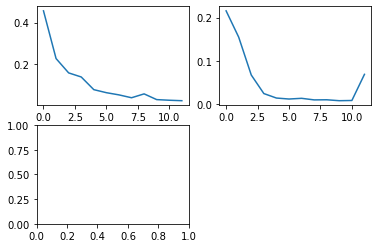

In [18]:
plt.subplot(2, 2, 1).plot(train_losses, label="train_loss")
plt.subplot(2, 2, 2).plot(val_losses, label="val_loss")
plt.subplot(2, 2, 3).plot([x.cpu() for x in train_metrics], label="train_metric")
plt.subplot(2, 2, 4).plot([x.cpu() for x in val_metrics], label="val_metric")
plt.subplot(2, 2, 1).legend()
plt.subplot(2, 2, 2).legend()
plt.subplot(2, 2, 3).legend()
plt.subplot(2, 2, 4).legend()

In [21]:
test_model = SiameseNetwork()
test_model.load_state_dict(torch.load("bestmodel4.pt"))
test_model.to(device);

## Testing

In [22]:
compute_metric(test_model, metric=metric, loader=val_loader)

100%|██████████| 71/71 [00:05<00:00, 12.68it/s]


(0.012678521017770875, 0.9949431075176722)